<a href="https://github.com/labrijisaad/Kedro-Energy-Forecasting-Machine-Learning-Pipeline/blob/main/notebooks/Machine Learning - Energy_Forecasting.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-GitHub-blue.svg" alt="Open In GitHub"/>
</a>

## <center><a><span style="color:red">Kedro `Machine Learning` - Energy Forecasting Dataset</span></a></center>

Now, we will create the Machine Learning workflow to train a model for future predictions. In this scenario, we'll concentrate on one prediction horizon, **Short-term (`1-Day`):** Our goal is to perform **next-day predictions**. [Explore `1-Day` Future Predictions](#1-Day). The purpose of this notebook is to prototype before developing the Kedro pipelines. For reference to this code: [Kedro-Energy-Forecasting-Machine-Learning-Pipeline](https://github.com/labrijisaad/Kedro-Energy-Forecasting-Machine-Learning-Pipeline/tree/main/src/energy_forcasting_model/pipelines).

### Import the needed libraries

In [1]:
# Supress warnings
import warnings

warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 4)
import numpy as np

# Visualization
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import seaborn as sns

color_pal = sns.color_palette("husl", 9)
sns.set(style="whitegrid")

import plotly.graph_objects as go

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# XGBoost
import xgboost as xgb

# Utilities

# Data missingness visualization

# Progress bar

#### Load Processed Data

In [2]:
weather_and_consumption_df = pd.read_csv(
    "../data/02_processed/processed_weather_and_consumption_data.csv",
    index_col=0,
    parse_dates=True,
)
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889,False


In [3]:
weather_and_consumption_df.columns

Index(['total_consumption', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
       'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'conditions_snowovercast',
       'conditions_snowpartiallycloudy', 'conditions_snowrain',
       'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
       'day_length', 'is_holiday'],
      dtype='object')

#### Copy the Data

In [4]:
df = weather_and_consumption_df.copy()

## <center><a class="anchor" id="1-Day"><span style="color:green">Training Models for `1-Day` Future Predictions</span></a></center>

### <a><span style="color:red">Feature Engineering based on the `EDA`</span></a>

In [5]:
def create_features(df, column_names, lags, window_sizes):
    """
    Create time series features based on time series index and add lag and rolling features for specified columns.
    """
    # List to store created feature names
    created_features = []

    # Basic time series features
    basic_features = ["dayofweek", "quarter", "month", "year", "dayofyear"]
    for feature in basic_features:
        # Add basic time series features to the DataFrame
        df[feature] = getattr(df.index, feature)
        created_features.append(feature)

    for column_name in column_names:
        # Lag features for each specified column
        for lag in lags:
            lag_feature_name = f"{column_name}_lag_{lag}"
            df[lag_feature_name] = df[column_name].shift(lag)
            created_features.append(lag_feature_name)

        # Rolling window features for each specified column
        for window in window_sizes:
            rolling_mean_name = f"{column_name}_rolling_mean_{window}"
            df[rolling_mean_name] = (
                df[column_name].shift(1).rolling(window=window).mean()
            )
            created_features.append(rolling_mean_name)

    return df, created_features

In [6]:
# Apply the Feature Engineering Function
df, created_features = create_features(
    df,
    column_names=[
        "total_consumption",
        "Global_intensity",
        "Sub_metering_3",
        "Sub_metering_1",
        "temp",
        "day_length",
        "tempmax",
        "feelslike",
        "feelslikemax",
        "feelslikemin",
        "tempmin",
    ],
    lags=[1, 2, 3, 4, 5, 6, 7, 30, 90, 365],
    window_sizes=[2, 3, 4, 5, 6, 7, 30, 90, 365],
)

### <a><span style="color:red">Train / Test Split</span></a>
#### Define The Features and the Target

In [7]:
# External Features that we managed to add
EXTERNAL_FEATURES = [
    "tempmax",
    "tempmin",
    "temp",
    "feelslikemax",
    "feelslikemin",
    "feelslike",
    "dew",
    "humidity",
    "precip",
    "precipprob",
    "precipcover",
    "snow",
    "snowdepth",
    "windgust",
    "windspeed",
    "winddir",
    "sealevelpressure",
    "cloudcover",
    "visibility",
    "moonphase",
    "conditions_clear",
    "conditions_overcast",
    "conditions_partiallycloudy",
    "conditions_rain",
    "conditions_rainovercast",
    "conditions_rainpartiallycloudy",
    "conditions_snowovercast",
    "conditions_snowpartiallycloudy",
    "conditions_snowrain",
    "conditions_snowrainovercast",
    "conditions_snowrainpartiallycloudy",
    "day_length",
    "is_holiday",
]

# Features got with feature engineering
FEATURES = created_features

# Target Column
TARGET = "total_consumption"

In [8]:
df.tail(2)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday,dayofweek,quarter,month,year,dayofyear,total_consumption_lag_1,total_consumption_lag_2,total_consumption_lag_3,total_consumption_lag_4,total_consumption_lag_5,total_consumption_lag_6,total_consumption_lag_7,total_consumption_lag_30,total_consumption_lag_90,total_consumption_lag_365,total_consumption_rolling_mean_2,total_consumption_rolling_mean_3,total_consumption_rolling_mean_4,total_consumption_rolling_mean_5,total_consumption_rolling_mean_6,total_consumption_rolling_mean_7,total_consumption_rolling_mean_30,total_consumption_rolling_mean_90,total_consumption_rolling_mean_365,Global_intensity_lag_1,Global_intensity_lag_2,Global_intensity_lag_3,Global_intensity_lag_4,Global_intensity_lag_5,Global_intensity_lag_6,Global_intensity_lag_7,Global_intensity_lag_30,Global_intensity_lag_90,Global_intensity_lag_365,Global_intensity_rolling_mean_2,Global_intensity_rolling_mean_3,Global_intensity_rolling_mean_4,Global_intensity_rolling_mean_5,Global_intensity_rolling_mean_6,Global_intensity_rolling_mean_7,Global_intensity_rolling_mean_30,Global_intensity_rolling_mean_90,Global_intensity_rolling_mean_365,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_lag_3,Sub_metering_3_lag_4,Sub_metering_3_lag_5,Sub_metering_3_lag_6,Sub_metering_3_lag_7,Sub_metering_3_lag_30,Sub_metering_3_lag_90,Sub_metering_3_lag_365,Sub_metering_3_rolling_mean_2,Sub_metering_3_rolling_mean_3,Sub_metering_3_rolling_mean_4,Sub_metering_3_rolling_mean_5,Sub_metering_3_rolling_mean_6,Sub_metering_3_rolling_mean_7,Sub_metering_3_rolling_mean_30,Sub_metering_3_rolling_mean_90,Sub_metering_3_rolling_mean_365,Sub_metering_1_lag_1,Sub_metering_1_lag_2,Sub_metering_1_lag_3,Sub_metering_1_lag_4,Sub_metering_1_lag_5,Sub_metering_1_lag_6,Sub_metering_1_lag_7,Sub_metering_1_lag_30,Sub_metering_1_lag_90,Sub_metering_1_lag_365,Sub_metering_1_rolling_mean_2,Sub_metering_1_rolling_mean_3,Sub_metering_1_rolling_mean_4,Sub_metering_1_rolling_mean_5,Sub_metering_1_rolling_mean_6,Sub_metering_1_rolling_mean_7,Sub_metering_1_rolling_mean_30,Sub_metering_1_rolling_mean_90,Sub_metering_1_rolling_mean_365,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7,temp_lag_30,temp_lag_90,temp_lag_365,temp_rolling_mean_2,temp_rolling_mean_3,temp_rolling_mean_4,temp_rolling_mean_5,temp_rolling_mean_6,temp_rolling_mean_7,temp_rolling_mean_30,temp_rolling_mean_90,temp_rolling_mean_365,day_length_lag_1,day_length_lag_2,day_length_lag_3,day_length_lag_4,day_length_lag_5,day_length_lag_6,day_length_lag_7,day_length_lag_30,day_length_lag_90,day_length_lag_365,day_length_rolling_mean_2,day_length_rolling_mean_3,day_length_rolling_mean_4,day_length_rolling_mean_5,day_length_rolling_mean_6,day_length_rolling_mean_7,day_length_rolling_mean_30,day_length_rolling_mean_90,day_length_rolling_mean_365,tempmax_lag_1,tempmax_lag_2,tempmax_lag_3,tempmax_lag_4,tempmax_lag_5,tempmax_lag_6,tempmax_lag_7,tempmax_lag_30,tempmax_lag_90,tempmax_lag_365,tempmax_rolling_mean_2,tempmax_rolling_mean_3,tempmax_rolling_mean_4,tempmax_rolling_mean_5,tempmax_rolling_mean_6,tempmax_rolling_mean_7,tempmax_rolling_mean_30,tempmax_rolling_mean_90,tempmax_rolling_mean_365,feelslike_lag_1,feelslike_lag_2,feelslike_lag_3,feelslike_lag_4,feelslike_lag_5,feelslike_lag_6,feelslike_lag_7,feelslike_lag_30,feelslike_lag_90,feelslike_lag_365,feelslike_rolling_mean_2,feelslike_rolling_mean_3,feelslike_rolling_mean_4,feelslike_rol

Let's first train the model on historical data and evaluate its performance in the future. We can split the data as follows:
- Training data consists of records where the date is before `2010-05-17`.
- Testing data consists of records where the date is on or after `2010-05-17`

##### Define the Train / Test Data

In [9]:
# Define a Threshold
threshold = "2010-05-17"

# Splitting the data into train and test sets based on the defined Threshold
train_df = df.loc[df.index < threshold].copy()
test_df = df.loc[df.index >= threshold].copy()

# Define the X_train / y_train
X_train = train_df[FEATURES + EXTERNAL_FEATURES]
y_train = train_df[TARGET]

# Define the X_test / y_test
X_test = test_df[FEATURES + EXTERNAL_FEATURES]
y_test = test_df[TARGET]

##### Plot the Train / Test Data

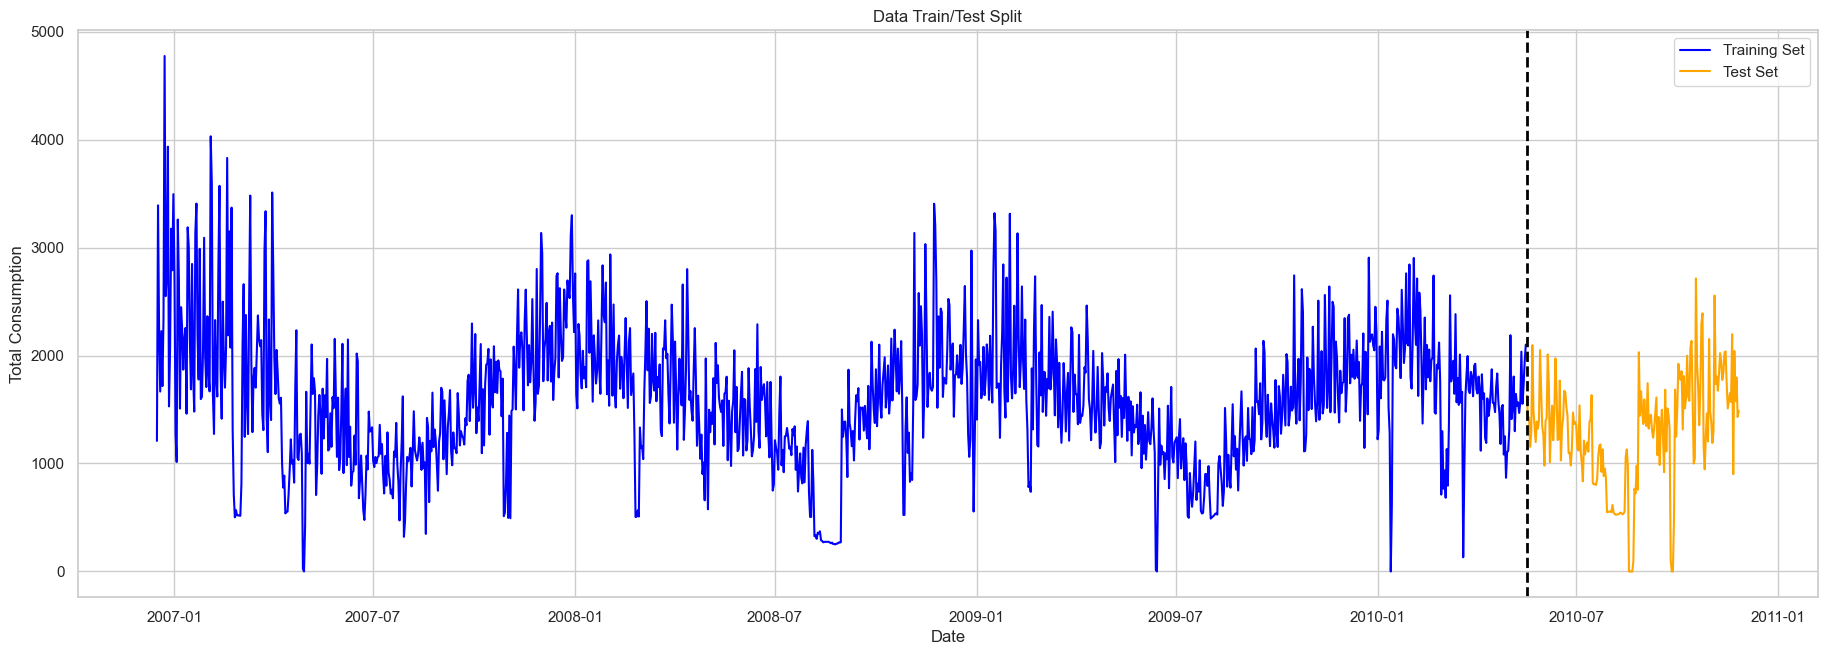

In [10]:
# Initialize the figure
plt.figure(figsize=(20, 7))

date_threshold = pd.to_datetime(threshold)

# Plot training and test sets
sns.lineplot(
    data=train_df,
    x=train_df.index,
    y="total_consumption",
    label="Training Set",
    color="blue",
)
sns.lineplot(
    data=test_df,
    x=test_df.index,
    y="total_consumption",
    label="Test Set",
    color="orange",
)

# Add vertical line for train-test split
plt.axvline(x=date_threshold, color="black", linestyle="--", lw=2)

# Customize the axes and title
plt.title("Data Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Total Consumption")

# Show plot
plt.show()

### <a><span style="color:red">Training Models for Predicting `1-Day` Ahead</span></a>

In this scenario, our goal is to train a model to forecast values one day into the future. This task involves using a **1-day lag**, which makes the challenge quite straightforward. We expect the 1-day lag feature to be crucial after training.

To evaluate performance, we'll develop and train several types of models: a **Random Forest**, an **XGBoost regressor** models.s.

In [11]:
X_train.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'total_consumption_lag_1', 'total_consumption_lag_2',
       'total_consumption_lag_3', 'total_consumption_lag_4',
       'total_consumption_lag_5',
       ...
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'conditions_snowovercast',
       'conditions_snowpartiallycloudy', 'conditions_snowrain',
       'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
       'day_length', 'is_holiday'],
      dtype='object', length=247)

#### Instantiate Models

In [41]:
# Instantiate Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=600, max_depth=3)

# Instantiate XGBoost Regressor

xgb = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=3,
    learning_rate=0.01,
)

# Create an instance of LGBMRegressor

lgb = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.2,
    n_estimators=1000,
    force_col_wise=True,
)

#### Train Models

In [42]:
# Train the Random Forest Regressor model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=600)

In [43]:
# Train the XGBoost Regressor
xgb.fit(
    X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_train, y_train)]
)

[0]	validation_0-rmse:1692.35197	validation_1-rmse:1692.35197
[100]	validation_0-rmse:730.39091	validation_1-rmse:730.39091
[200]	validation_0-rmse:441.24195	validation_1-rmse:441.24195
[300]	validation_0-rmse:363.25035	validation_1-rmse:363.25035
[400]	validation_0-rmse:335.57598	validation_1-rmse:335.57598
[500]	validation_0-rmse:320.57238	validation_1-rmse:320.57238
[600]	validation_0-rmse:306.52118	validation_1-rmse:306.52118
[700]	validation_0-rmse:293.97399	validation_1-rmse:293.97399
[800]	validation_0-rmse:283.77272	validation_1-rmse:283.77272
[900]	validation_0-rmse:274.68401	validation_1-rmse:274.68401
[999]	validation_0-rmse:266.52789	validation_1-rmse:266.52789


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [44]:
# Train the model
lgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric="l2")

[LightGBM] [Info] Total Bins 55973
[LightGBM] [Info] Number of data points in the train set: 1248, number of used features: 240
[LightGBM] [Info] Start training from score 1591.181481


LGBMRegressor(force_col_wise=True, learning_rate=0.2, n_estimators=1000)

#### Plot the Feature Importance

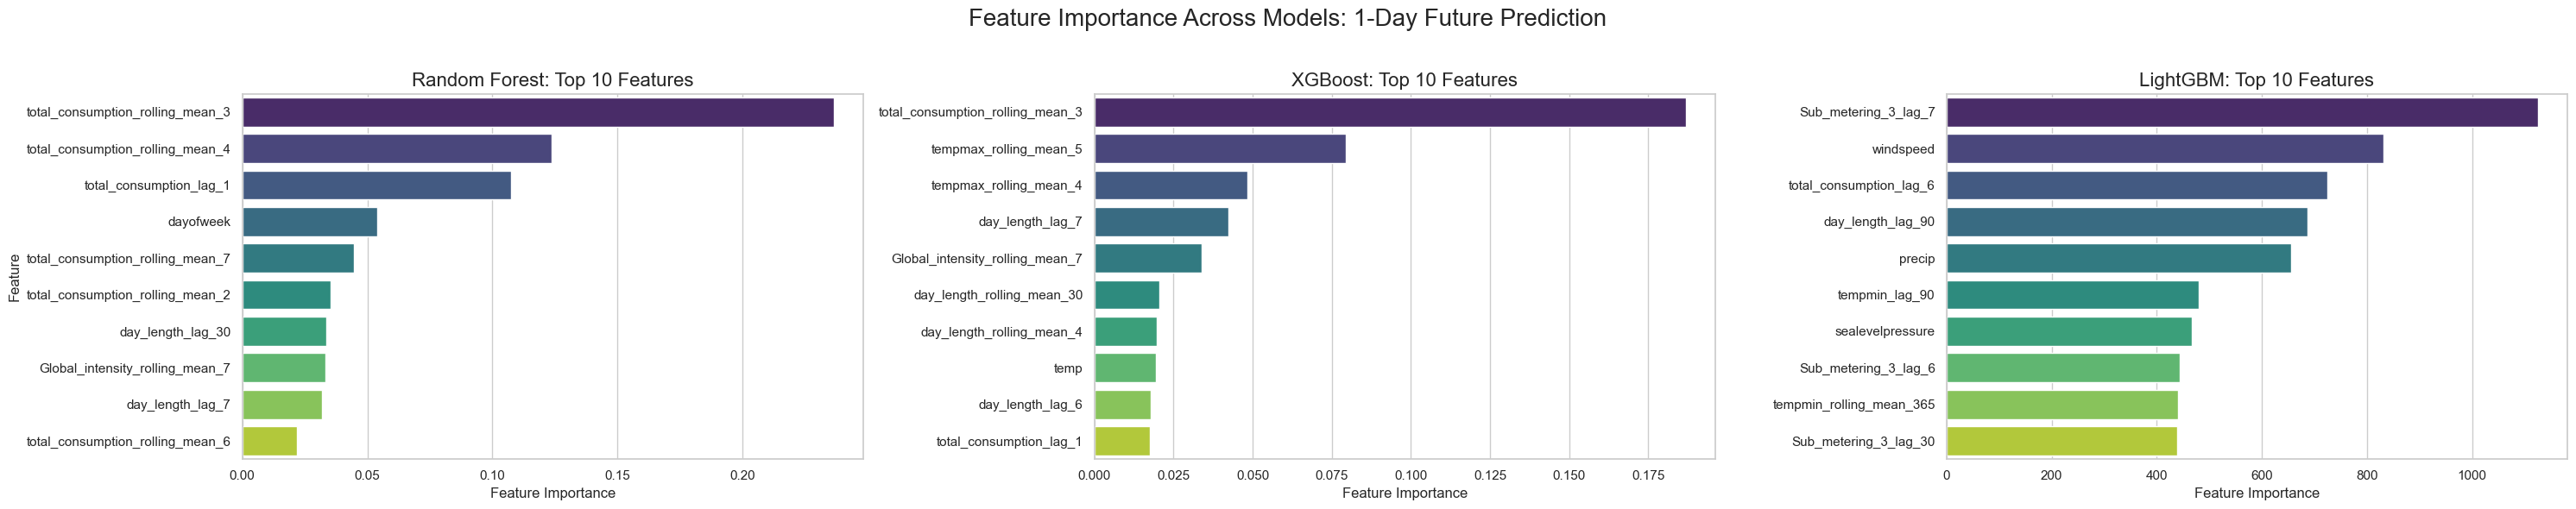

In [45]:
# Create DataFrame for feature importances for each model
feature_data_rfr = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": rfr.feature_importances_,
        "Model": "Random Forest",
    }
)

feature_data_xgb = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": xgb.feature_importances_,
        "Model": "XGBoost",
    }
)

feature_data_lgb = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": lgb.feature_importances_,
        "Model": "LightGBM",
    }
)

# Combine the DataFrames
feature_data_combined = pd.concat(
    [feature_data_rfr, feature_data_xgb, feature_data_lgb]
)

# Sort each DataFrame by importance and select the top 10 features for each model
top_features_rfr = feature_data_rfr.sort_values(by="Importance", ascending=False).head(
    10
)
top_features_xgb = feature_data_xgb.sort_values(by="Importance", ascending=False).head(
    10
)
top_features_lgb = feature_data_lgb.sort_values(by="Importance", ascending=False).head(
    10
)  # Now defined correctly

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(30, 6))  # Adjust for 3 plots

# Random Forest
sns.barplot(
    data=top_features_rfr, x="Importance", y="Feature", palette="viridis", ax=axs[0]
)
axs[0].set_title("Random Forest: Top 10 Features", fontsize=16)
axs[0].set_xlabel("Feature Importance", fontsize=12)
axs[0].set_ylabel("Feature", fontsize=12)

# XGBoost
sns.barplot(
    data=top_features_xgb, x="Importance", y="Feature", palette="viridis", ax=axs[1]
)
axs[1].set_title("XGBoost: Top 10 Features", fontsize=16)
axs[1].set_xlabel("Feature Importance", fontsize=12)
axs[1].set_ylabel("", fontsize=12)  # Remove y-label for neatness

# LightGBM
sns.barplot(
    data=top_features_lgb, x="Importance", y="Feature", palette="viridis", ax=axs[2]
)
axs[2].set_title("LightGBM: Top 10 Features", fontsize=16)
axs[2].set_xlabel("Feature Importance", fontsize=12)
axs[2].set_ylabel("", fontsize=12)  # Remove y-label for neatness

# Add main title and adjust layout
plt.suptitle("Feature Importance Across Models: 1-Day Future Prediction", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

#### Analyse the Models Performances - plotly

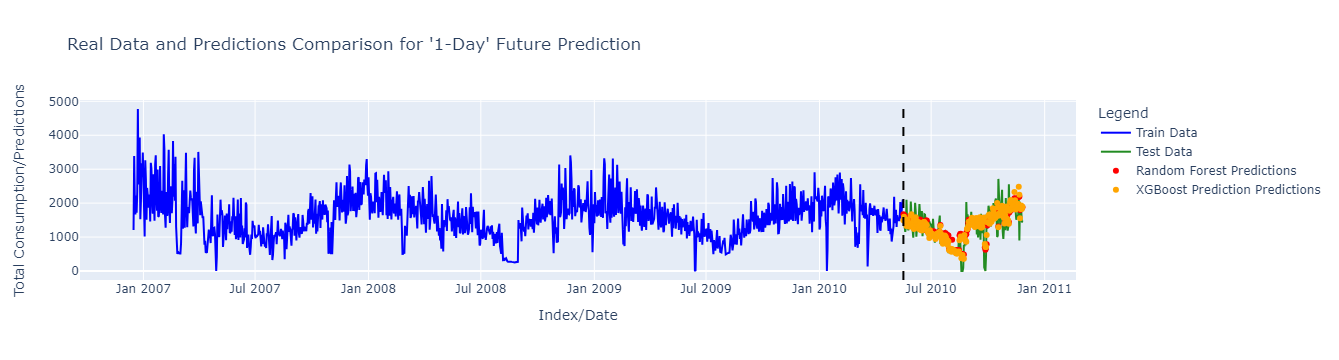

Random Forest RMSE: 362.17807965948725
XGBoost RMSE: 367.481973834411


In [46]:
# Adding Random Forest predictions to the test set DataFrame
test_df["RandomForest_Prediction"] = rfr.predict(X_test)
test_df["XGBoost_Prediction"] = xgb.predict(X_test)

df_final = df.merge(
    test_df[["RandomForest_Prediction", "XGBoost_Prediction"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Plotly graph for truth data and predictions
train_data = go.Scatter(
    x=train_df.index,
    y=train_df["total_consumption"],
    mode="lines",
    name="Train Data",
    line=dict(color="Blue"),
)
test_data = go.Scatter(
    x=test_df.index,
    y=test_df["total_consumption"],
    mode="lines",
    name="Test Data",
    line=dict(color="ForestGreen"),
)
random_forest_predictions = go.Scatter(
    x=df_final.index,
    y=df_final["RandomForest_Prediction"],
    mode="markers",
    name="Random Forest Predictions",
    marker=dict(color="Red"),
)
xgboost_predictions = go.Scatter(
    x=df_final.index,
    y=df_final["XGBoost_Prediction"],
    mode="markers",
    name="XGBoost Prediction Predictions",
    marker=dict(color="Orange"),
)

# Adding a vertical line for the train-test split date
vline = dict(
    type="line",
    x0=threshold,
    y0=0,
    x1=threshold,
    y1=1,
    line=dict(color="Black", width=2, dash="dash"),
    xref="x",
    yref="paper",
)
# Update layout for a better visual presentation
layout = go.Layout(
    title="Real Data and Predictions Comparison for '1-Day' Future Prediction",
    xaxis=dict(title="Index/Date"),
    yaxis=dict(title="Total Consumption/Predictions"),
    legend_title="Legend",
    shapes=[vline],
)

fig = go.Figure(
    data=[train_data, test_data, random_forest_predictions, xgboost_predictions],
    layout=layout,
)

# Show the interactive plot
fig.show()

# Calculate the RMSE for the Random Forest Model on the Test Data
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print(f"Random Forest RMSE: {rmse_rfr}")

# Calculate the RMSE for the XGBoost Model on the Test Data
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

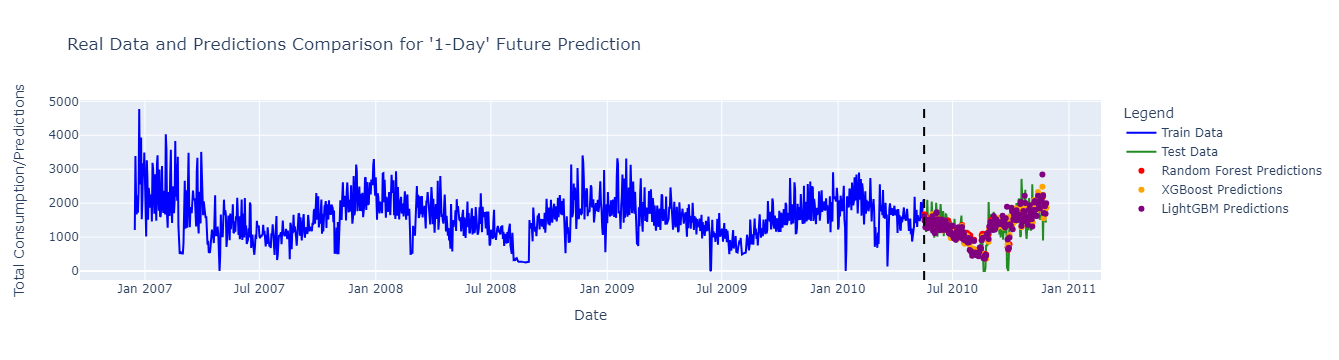

Random Forest RMSE: 362.17807965948725
XGBoost RMSE: 367.481973834411
LightGBM RMSE: 382.7030069961726


In [47]:
# Adding Random Forest, XGBoost and LightGBM predictions to the test set DataFrame
test_df["RandomForest_Prediction"] = rfr.predict(X_test)
test_df["XGBoost_Prediction"] = xgb.predict(X_test)
test_df["LightGBM_Prediction"] = lgb.predict(X_test)

# Merging the predictions into the main DataFrame
df_final = df.merge(
    test_df[["RandomForest_Prediction", "XGBoost_Prediction", "LightGBM_Prediction"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Plotly graph objects for training data, test data, and predictions
train_data = go.Scatter(
    x=train_df.index,
    y=train_df["total_consumption"],
    mode="lines",
    name="Train Data",
    line=dict(color="Blue"),
)
test_data = go.Scatter(
    x=test_df.index,
    y=test_df["total_consumption"],
    mode="lines",
    name="Test Data",
    line=dict(color="ForestGreen"),
)
random_forest_predictions = go.Scatter(
    x=df_final.index,
    y=df_final["RandomForest_Prediction"],
    mode="markers",
    name="Random Forest Predictions",
    marker=dict(color="Red"),
)
xgboost_predictions = go.Scatter(
    x=df_final.index,
    y=df_final["XGBoost_Prediction"],
    mode="markers",
    name="XGBoost Predictions",
    marker=dict(color="Orange"),
)
lightgbm_predictions = go.Scatter(
    x=df_final.index,
    y=df_final["LightGBM_Prediction"],
    mode="markers",
    name="LightGBM Predictions",
    marker=dict(color="Purple"),
)

# Adding a vertical line for the train-test split date
vline = dict(
    type="line",
    x0=threshold,  # Replace 'threshold' with the actual date or index of the split
    y0=0,
    x1=threshold,
    y1=1,
    line=dict(color="Black", width=2, dash="dash"),
    xref="x",
    yref="paper",
)

# Layout configuration
layout = go.Layout(
    title="Real Data and Predictions Comparison for '1-Day' Future Prediction",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Total Consumption/Predictions"),
    legend_title="Legend",
    shapes=[vline],
)

# Creating the figure and showing the plot
fig = go.Figure(
    data=[
        train_data,
        test_data,
        random_forest_predictions,
        xgboost_predictions,
        lightgbm_predictions,
    ],
    layout=layout,
)
fig.show()

# Performance Evaluation (RMSE) for each model
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print(f"Random Forest RMSE: {rmse_rfr}")

y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

y_pred_lgb = lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"LightGBM RMSE: {rmse_lgb}")

#### Analyse the Models Performances - seaborn

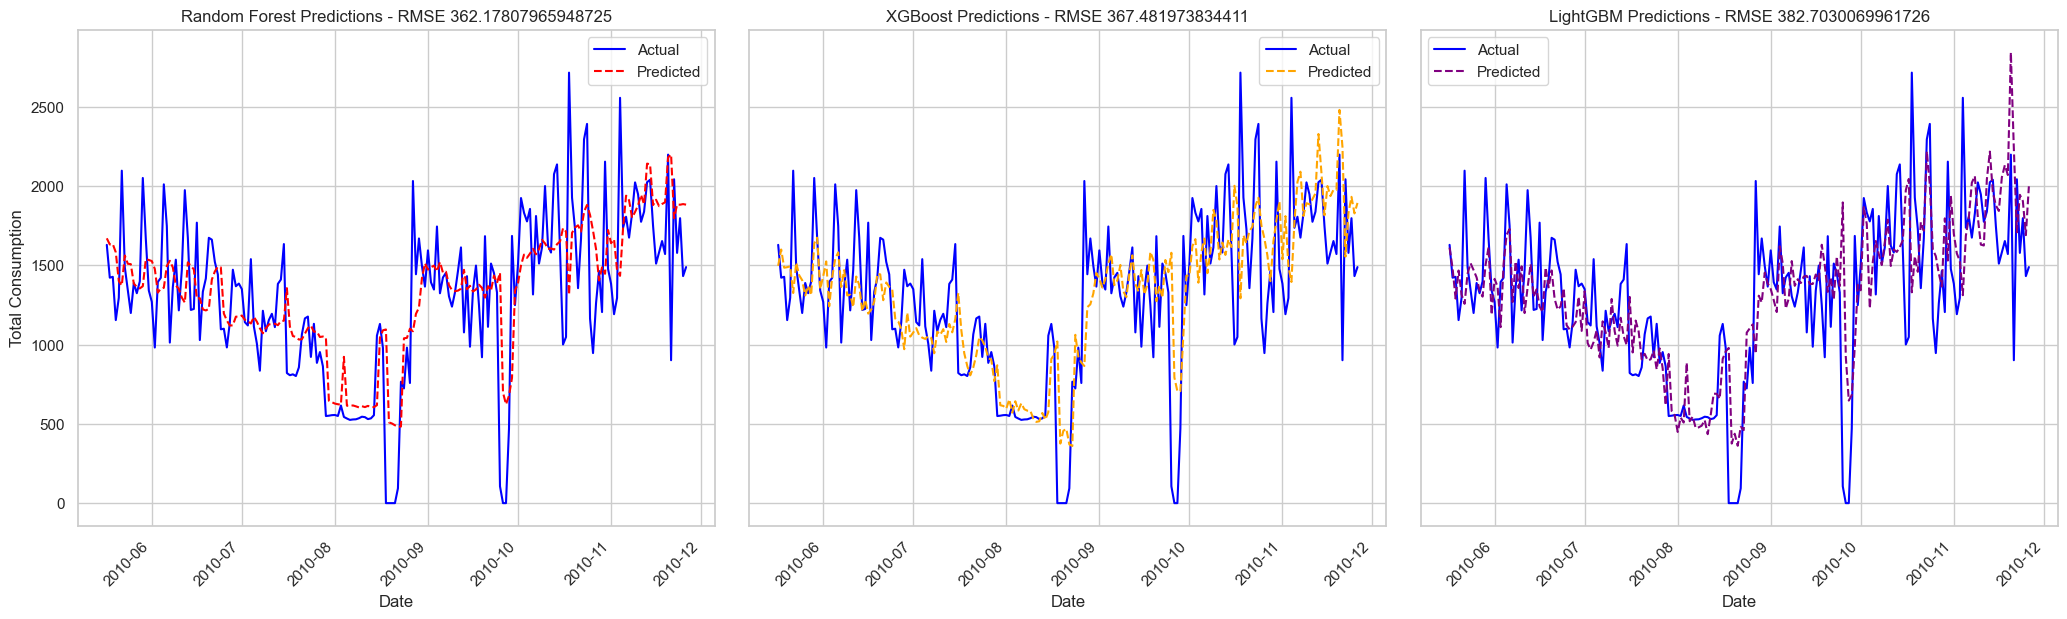

In [48]:
# Creating subplots: 3 columns, 1 row
fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

# Random Forest predictions and RMSE
axs[0].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Actual",
    color="blue",
    linestyle="-",
    markersize=5,
)
axs[0].plot(
    test_df.index,
    test_df["RandomForest_Prediction"],
    label="Predicted",
    color="red",
    linestyle="--",
    markersize=5,
)
axs[0].set_title(f"Random Forest Predictions - RMSE {rmse_rfr}")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Total Consumption")
axs[0].legend()

# XGBoost predictions and RMSE
axs[1].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Actual",
    color="blue",
    linestyle="-",
    markersize=5,
)
axs[1].plot(
    test_df.index,
    test_df["XGBoost_Prediction"],
    label="Predicted",
    color="orange",
    linestyle="--",
    markersize=5,
)
axs[1].set_title(f"XGBoost Predictions - RMSE {rmse_xgb}")
axs[1].set_xlabel("Date")
axs[1].legend()

# LightGBM predictions and RMSE
axs[2].plot(
    test_df.index,
    test_df["total_consumption"],
    label="Actual",
    color="blue",
    linestyle="-",
    markersize=5,
)
axs[2].plot(
    test_df.index,
    test_df["LightGBM_Prediction"],
    label="Predicted",
    color="purple",
    linestyle="--",
    markersize=5,
)
axs[2].set_title(f"LightGBM Predictions - RMSE {rmse_lgb}")
axs[2].set_xlabel("Date")
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Rotate x-axis labels for better readability
for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

# Show the plot
plt.show()

## Connect with me 🌐
<div align="center">
  <a href="https://www.linkedin.com/in/labrijisaad/">
    <img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn" style="margin-bottom: 5px;"/>
  </a>
  <a href="https://github.com/labrijisaad">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub" style="margin-bottom: 5px;"/>
  </a>
</div>